In [1]:
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

In [2]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [3]:
modpath = os.path.dirname('/Users/jinkun.tian/gitee/financial_lab/')
datapath = os.path.join(modpath, 'strategy/data/yahoo/ORCL.csv')

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date   2021-07-12
    fromdate=datetime.datetime(2021, 7, 12),
    # Do not pass values after this date
    todate=datetime.datetime(2022, 7, 12),
    reverse=False)

Starting Portfolio Value: 1000.00
2021-08-26, Close, 87.35
2021-08-27, Close, 87.97
2021-08-30, Close, 88.07
2021-08-30, BUY CREATE, 88.07
2021-08-31, BUY EXECUTED, Price: 88.07, Cost: 880.70, Comm 0.00
2021-08-31, Close, 87.75
2021-08-31, SELL CREATE, 87.75
2021-09-01, SELL EXECUTED, Price: 87.88, Cost: 880.70, Comm 0.00
2021-09-01, OPERATION PROFIT, GROSS -1.90, NET -1.90
2021-09-01, Close, 88.56
2021-09-01, BUY CREATE, 88.56
2021-09-02, BUY EXECUTED, Price: 88.78, Cost: 887.80, Comm 0.00
2021-09-02, Close, 88.41
2021-09-03, Close, 88.61
2021-09-07, Close, 87.35
2021-09-07, SELL CREATE, 87.35
2021-09-08, SELL EXECUTED, Price: 86.78, Cost: 887.80, Comm 0.00
2021-09-08, OPERATION PROFIT, GROSS -20.00, NET -20.00
2021-09-08, Close, 88.09
2021-09-08, BUY CREATE, 88.09
2021-09-09, BUY EXECUTED, Price: 88.22, Cost: 882.20, Comm 0.00
2021-09-09, Close, 88.16
2021-09-10, Close, 88.30
2021-09-13, Close, 87.52
2021-09-13, SELL CREATE, 87.52
2021-09-14, SELL EXECUTED, Price: 84.86, Cost: 882.20

<IPython.core.display.Javascript object>


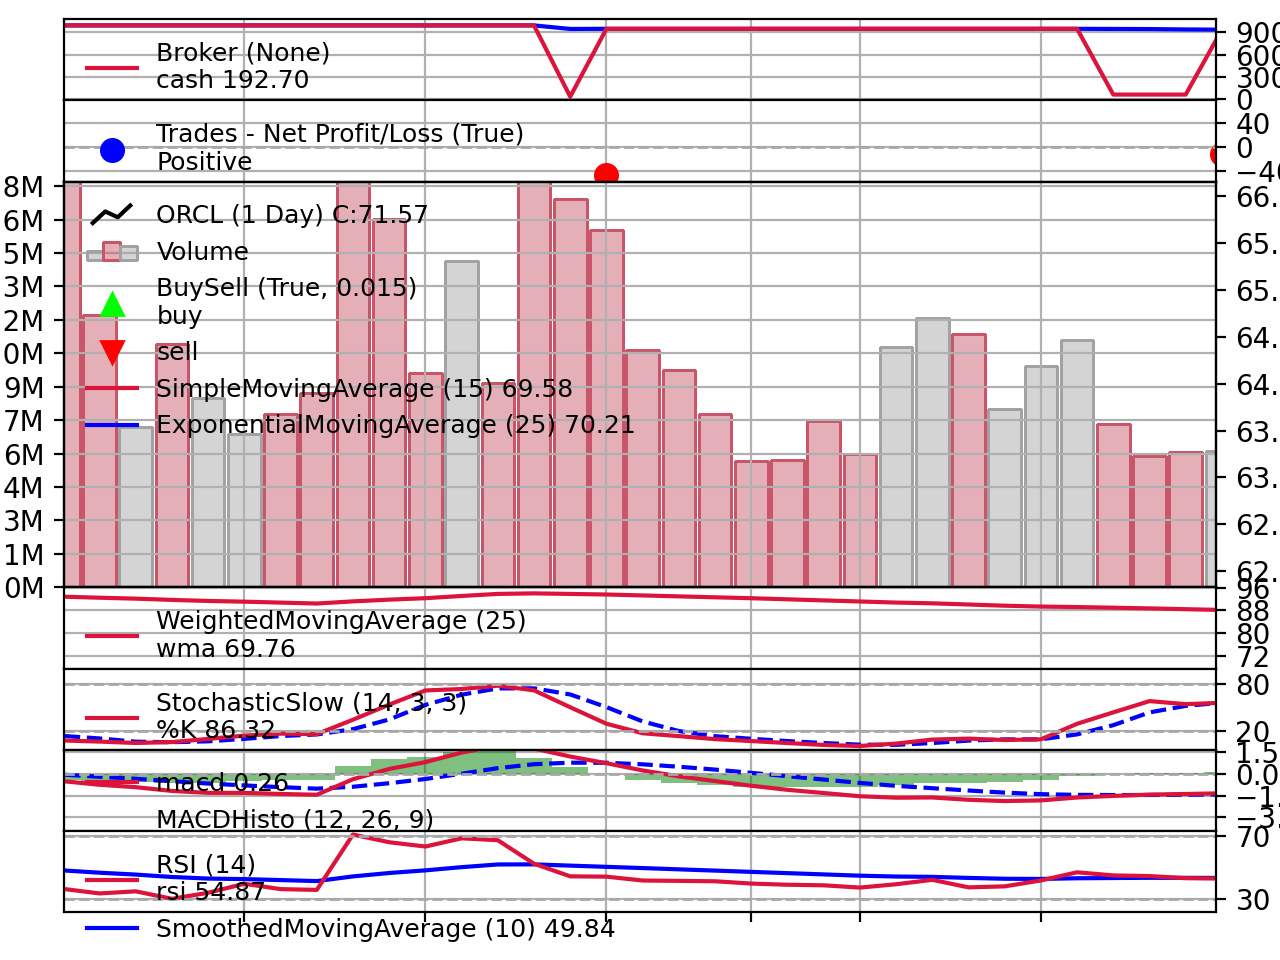

[[<Figure size 640x480 with 8 Axes>]]

In [4]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()

<IPython.core.display.Javascript object>


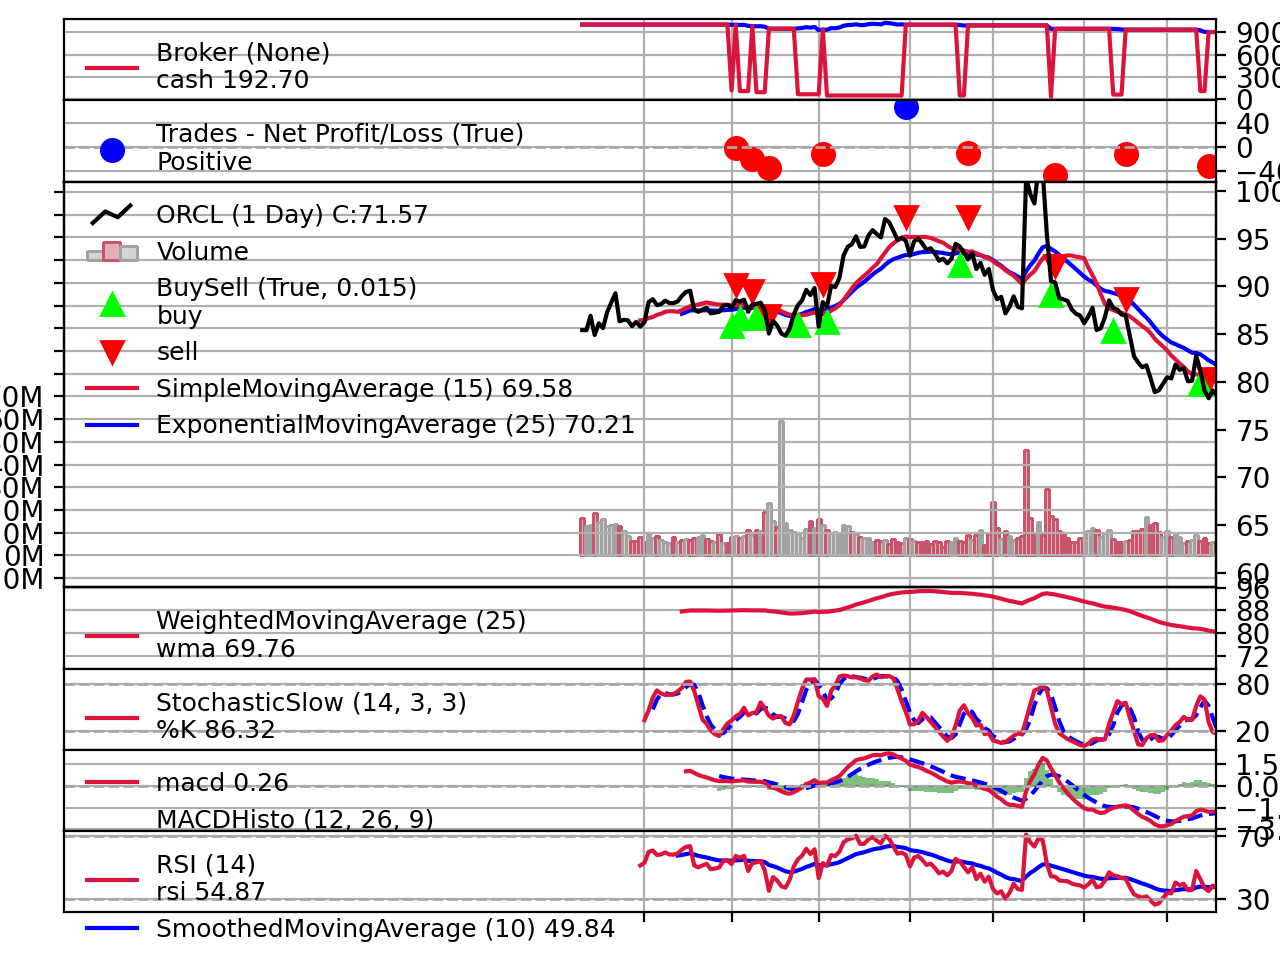

[[<Figure size 640x480 with 8 Axes>]]

In [5]:
# Plot the result
cerebro.plot()